In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy import linalg as la

In [2]:
def sghmc(U, gradU, m, dt, steps, x, C, V):
    """
    function applys sghmc shown in the paper
    """
    
    B = 0.5 * V * dt
    D = (2*(C-B)*dt)**0.5
    p = np.random.randn(1) * (m**0.5)
    for i in range(steps):
        x = x + dt * p / m
        p = p - dt * gradU(x) - dt * C * p/m -np.random.randn(1) * D
    return x

def hmc(U, gradU, m, dt, steps, x, MH):
    """
    function applys hmc 
    """
    x_pre = x
    p = np.random.randn(1) *(m**0.5)
    ener_before = (p**2) / (2*m) + U(x)
    
    for i in range(steps):
        p = p - dt*gradU(x)/2
        x = x + p*dt/m
        p = p - dt*gradU(x)/2
    
    if MH == True:
        ener_after = (p**2)/(2*m)+ U(x)
        y_uni = np.random.uniform(size=1)
        if (y_uni > np.exp(ener_before-ener_after)):
            # reject
            x = x_pre
    
    return x


def U(x):
    """
    posterior probability
    """
    return(-2 * x**2 + x**4)

def gradU(x):
    """
    gradient of the posterior probability
    """
    return(-4 * x + 4 * x**3 + 2*np.random.randn(1))


def gradU2(x):
    """
    the perfect gradient of the posterior probability
    """
    return(- 4 * x +  4 * x**3)

noise = 2*np.random.randn(1)

In [3]:
n = 8000
step = 0.1
m = 1
dt = 0.1
steps = 50
theta = np.arange(-3, 3, step=step)
C = 4
V = 4

In [4]:
## Standard HMC with MH

samples = np.zeros((n))

x = np.array([0])

for i in range(n):
    x = hmc(U, gradU2, m, dt, steps, x, True)
    samples[i] = x

y_hmc_HM= np.histogram(samples, theta)[0] / sum(np.histogram(samples, theta)[0])/step
x_hmc_HM = np.histogram(samples, theta)[1]

In [6]:
## Standard HMC without MH

samples = np.zeros((n))

x = np.array([0])

for i in range(n):
    x = hmc(U, gradU2, m, dt, steps, x, False)
    samples[i] = x
    
y_hmc_noHM = np.histogram(samples, theta)[0] / sum(np.histogram(samples, theta)[0])/step
x_hmc_noHM = np.histogram(samples, theta)[1]

In [7]:
samples = np.zeros((n))

x = np.array([0])

for i in range(n):
    x = hmc(U, gradU, m, dt, steps, x, False)
    samples[i] = x

x_naive_hmc_HM = np.histogram(samples, theta)[1]    
y_naive_hmc_HM = np.histogram(samples, theta)[0] / sum(np.histogram(samples, theta)[0])/step

In [10]:
samples = np.zeros((n))

x = np.array([0])

for i in range(n):
    x = hmc(U, gradU, m, dt, steps, x, True)
    samples[i] = x

y_naive_hmc_noHM = np.histogram(samples, theta)[0] / sum(np.histogram(samples, theta)[0])/step
x_naive_hmc_noHM = np.histogram(samples, theta)[1]

In [8]:
np.random.seed(663)

samples = np.zeros((n))

x = np.array([0])
for i in range(n):
    x = sghmc(U, gradU, m, dt, steps, x, C, V)
    samples[i] = x

x_sghmc = np.histogram(samples, theta)[1]
y_sghmc = np.histogram(samples, theta)[0] / sum((np.histogram(samples, theta)[0]))
y_sghmc = y_sghmc/step

y_true = np.exp(-U(theta)) / sum(np.exp(-U(theta))) / step

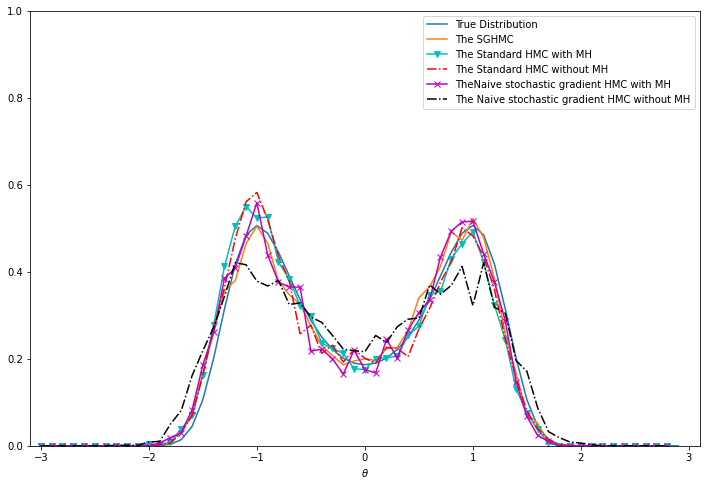

In [11]:
plt.figure(figsize = (12,8))
plt.plot(theta,y_true, label = 'True Distribution')
plt.plot(x_sghmc[:-1], y_sghmc, label = 'The SGHMC')
plt.plot(x_hmc_HM[:-1], y_hmc_HM, 'c-v', label = 'The Standard HMC with MH')
plt.plot(x_hmc_noHM[:-1], y_hmc_noHM, 'r-.', label = 'The Standard HMC without MH')
plt.plot(x_naive_hmc_noHM[:-1], y_naive_hmc_noHM, 'm-x', label = 'TheNaive stochastic gradient HMC with MH')
plt.plot(x_naive_hmc_HM[:-1], y_naive_hmc_HM, 'k-.', label = 'The Naive stochastic gradient HMC without MH')


plt.legend(loc = 1)
plt.xlim(-3.1, 3.1)
plt.ylim(0, 1)
plt.xlabel('$\\theta$')
plt.savefig("../figures/figure1.png")

In [13]:
def sghmc( U, gradU, ini, C, V, samples, steps=50, epsilon=0.1, seed = 663):
    """
    function applys sghmc shown in the paper
    """
    
    np.random.seed(seed)
    B = 0.5*V*epsilon
    C = np.asarray(C)
    V =  np.asarray(V)
    n_params = ini.shape[0]
    
    if n_params ==1:
        D = np.sqrt(2*(C-B)*epsilon)
    else:
        D =la.cholesky(2*(C-B)*epsilon) 
    
    samples2 = np.zeros((samples, n_params))
    samples2[0] = ini
    
    for i in range(samples-1):
        x = samples2[i]
        p = np.random.randn(n_params)
        for j in range(steps):
            x = x + epsilon * p
            p = p - epsilon * gradU(x) - epsilon * np.dot(C,p) - np.dot(D,np.random.randn(n_params))
        samples2[i+1] = x
    
    return samples2

In [14]:
S = np.array([[1, 0.9], [0.9, 1]])
S_inv = la.inv(S)
U = lambda x: 0.5 * x.T @ S_inv @ x
gradU = lambda x: S_inv @ x + np.random.randn(2)

ini = np.array([0,0])
C = 1*np.eye(2)
V = np.eye(2)
xs = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))[0]
ys = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))[1]

samples = sghmc(U, gradU, ini, C, V=np.eye(2), samples=50, steps=50, epsilon=0.1, seed = 663)

def probmap(x,y):
    return (np.exp(-0.5 * (S_inv[0,0]*x**2 + 2*S_inv[0,1]*x*y + S_inv[1,1]*y**2)))

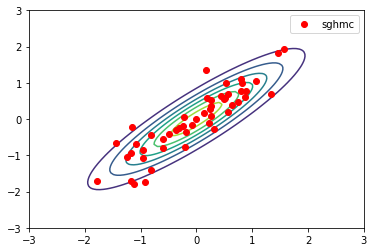

In [15]:
plt.contour(xs, ys, probmap(xs,ys))
plt.plot(samples[:,0], samples[:,1], 'ro', label='sghmc')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.legend()
plt.savefig("../figures/figure3.png")